In [1]:
import os
import numpy as np
import pandas as pd
from time import time
from tqdm.notebook import tqdm
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import copy
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score

In [3]:
import torch
from torch import nn
from torch.autograd import Variable

class ET_Rnn(torch.nn.Module):
    def __init__(self, dense_dims, sparse_dims, hidden_dims, n_layers=1, use_chid=True, cell='GRU', bi=False, dropout=0, device='cpu'):
        super(ET_Rnn, self).__init__()
        self.hidden_dims = hidden_dims
        self.n_layers = n_layers
        self.cell = cell
        self.use_chid = use_chid
        self.device = device
        self.bi = bi
        
        self.embedding_list = nn.ModuleList([nn.Embedding(fd, ed, padding_idx=0) for fd, ed in sparse_dims])
        
        if use_chid: 
            rnn_in_dim = dense_dims + sum([ed for fd, ed in sparse_dims[1:]])   
            self.out_dim = hidden_dims*(bi+1) + sparse_dims[0][1] # chid embed dim
            self.user_layer = nn.Linear(sparse_dims[0][1], sparse_dims[0][1]) 
            
        else:
            rnn_in_dim = dense_dims + sum([ed for fd, ed in sparse_dims[:]])
            self.out_dim = hidden_dims*(bi+1)
        
        if self.cell == 'LSTM':
            self.rnn = nn.LSTM(rnn_in_dim, hidden_dims, n_layers, batch_first=True, bidirectional=bi, dropout=dropout)
        elif self.cell == 'GRU':
            self.rnn = nn.GRU(rnn_in_dim, hidden_dims, n_layers, batch_first=True, bidirectional=bi, dropout=dropout)    
        
        self.init_embedding()
        
    def init_embedding(self):
        for embed in self.embedding_list:
            embed.reset_parameters()

    def init_hidden(self, x):
        if self.cell == 'LSTM':
            hidden = Variable(torch.zeros(self.n_layers*(self.bi+1), x.size(0), self.hidden_dims)).to(self.device)
            context = Variable(torch.zeros(self.n_layers*(self.bi+1), x.size(0), self.hidden_dims)).to(self.device)
            ret = (hidden, context)
        elif self.cell == 'GRU':
            hidden = Variable(torch.zeros(self.n_layers*(self.bi+1), x.size(0), self.hidden_dims)).to(self.device)
            ret = hidden
        
        return ret
            
    def forward(self, x_dense, x_sparse):
        if self.use_chid:
            x = torch.cat([x_dense]+[embed(x_sparse[:, :, i+1]) for i, embed in enumerate(self.embedding_list[1:])], dim=-1)            
        else:
            x = torch.cat([x_dense]+[embed(x_sparse[:, :, i]) for i, embed in enumerate(self.embedding_list[:])], dim=-1)
        
        self.hidden = self.init_hidden(x)
        logits, self.hidden = self.rnn(x, self.hidden)
        
        if self.use_chid:
            user_embed = self.user_layer(self.embedding_list[0](x_sparse[:,0,0]))
            last_logits = torch.cat([logits[:, -1], user_embed], dim=-1)
        else:
            last_logits = logits[:, -1]
        
        return last_logits

In [4]:
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims=[1], out_dim=1):
        super(MLP, self).__init__()
        hidden_dims = [input_dims] + hidden_dims
        
        self.layers = nn.Sequential(*[
            nn.Sequential(
                nn.Linear(idim, odim), 
                nn.ReLU()
            ) for idim, odim in zip(hidden_dims[:-1], hidden_dims[1:])
        ])
        
        self.out_layer = nn.Linear(hidden_dims[-1], out_dim)
                   
    def forward(self, x):
        out = self.layers(x)
        out = self.out_layer(out)
        
        return out

In [5]:
class SingleTaskModel(nn.Module):
    def __init__(self, dense_dims, sparse_dims, hidden_dims, out_dim=1, n_layers=1, use_chid=True, cell='GRU', bi=False, dropout=0, device='cpu'):
        super(SingleTaskModel, self).__init__()
        self.rnn = ET_Rnn(dense_dims, sparse_dims, hidden_dims, n_layers=n_layers, use_chid=use_chid, 
                          cell=cell, bi=bi, dropout=dropout, device=device)
        
        self.mlp = MLP(self.rnn.out_dim, hidden_dims=[self.rnn.out_dim//2], out_dim=out_dim)
        
    def forward(self, x_dense, x_sparse):
        logits = self.rnn(x_dense, x_sparse)
        out = self.mlp(logits)
        
        return out        

In [6]:
class Trainer:
    def __init__(self, model, criterion, optimizer, device='cpu'):
        self.model = model.to(device)
        self.criterion = criterion
        self.optimizer = optimizer
        self.device = device
        
    def fit(self, train_loader, test_loader=None, epoch=1, early_stop=-1, eval_type='RMSE', scaler=None):
        history = {
            'train': [], 
            'test': []
        }
        
        best_eval = 9e9
        early_cnt = 0
        best_model_params = copy.deepcopy(self.model.state_dict())
        
        for ep in tqdm(range(epoch)):
            #print('Epoch:{}'.format(ep+1))
            
            for batch in train_loader:
                self.model.train()
                self.optimizer.zero_grad()
                
                x_dense, x_sparse, y = [b.to(self.device) for b in batch]
                
                output = self.model(x_dense, x_sparse)
                loss = self.criterion(output, y)

                loss.backward()
                self.optimizer.step()
                
            train_result, _, _ = self.evaluate(train_loader, scaler)
            history['train'].append(train_result)
            #print('\ttrain\t'+' '.join(['{}:{:.2f}'.format(k, v) for k, v in train_result.items()]))
            
            if test_loader:
                test_result, _, _ = self.evaluate(test_loader, scaler)
                history['test'].append(test_result)
                
                if ep%5 == 0 or ep == epoch-1:
                    print('Epoch:{}'.format(ep+1))
                    print('\ttest\t'+' '.join(['{}:{:.3f}'.format(k, v) for k, v in test_result.items()]))                

                if test_result[eval_type] < best_eval:
                    early_cnt = 0
                    best_eval = test_result[eval_type]
                    best_model_params = copy.deepcopy(self.model.state_dict())
                    #print('\tbetter!')

                elif early_stop > 0:
                    early_cnt += 1

            if early_stop > 0 and early_cnt >= early_stop:
                break
        
        self.model.load_state_dict(best_model_params)
        
        return history
        
    def evaluate(self, loader, scaler=None):
        true_list = []
        pred_list = []
        
        self.model.eval()
        for batch in loader:
            x_dense, x_sparse, y = [b.to(self.device) for b in batch]
            output = self.model(x_dense, x_sparse)
            
            true_list.append(y.cpu().detach().numpy())
            pred_list.append(output.cpu().detach().numpy())
        
        true_list = np.concatenate(true_list, axis=0)
        pred_list = np.concatenate(pred_list, axis=0)
        
        true_list = np.expm1(scaler.inverse_transform(true_list) if scaler else true_list)
        pred_list = np.expm1(scaler.inverse_transform(pred_list) if scaler else pred_list)
        
        result = {
            'RMSE': mean_squared_error(true_list, pred_list, squared=False), 
            'MAE(mean)': mean_absolute_error(true_list, pred_list), 
            'MAE(median)': median_absolute_error(true_list, pred_list)
        }
        
        return result, true_list, pred_list

In [7]:
sample_path = './data/sample_50k'

x_train = np.load(os.path.join(sample_path, 'RNN', 'x_train.npy'), allow_pickle=True)
x_test = np.load(os.path.join(sample_path, 'RNN', 'x_test.npy'), allow_pickle=True)

#f_train = np.load(os.path.join(sample_path, 'RNN', 'f_train.npy'), allow_pickle=True)
#f_test = np.load(os.path.join(sample_path, 'RNN', 'f_test.npy'), allow_pickle=True)

Y_train = np.load(os.path.join(sample_path, 'RNN', 'y_train.npy'), allow_pickle=True)
Y_test = np.load(os.path.join(sample_path, 'RNN', 'y_test.npy'), allow_pickle=True)

chid_mapper = np.load(os.path.join(sample_path, 'sample_50k_chid_idx_map.npy'), allow_pickle=True).item()
feat_mapper = np.load(os.path.join(sample_path, 'RNN', 'feature_map.npy'), allow_pickle=True).item()
cust_feature_map = np.load(os.path.join(sample_path, 'RNN', 'cust_feature_map.npy'), allow_pickle=True).item()

columns = np.load(os.path.join(sample_path, 'RNN', 'columns.npy'), allow_pickle=True).item()

print(x_train.shape, x_test.shape, Y_train.shape, Y_test.shape, len(chid_mapper))
print([(k, len(v)) for k, v in feat_mapper.items()], [(k, len(v)) for k, v in cust_feature_map.items()])

(1033871, 120, 14) (100000, 120, 14) (1033871, 7) (100000, 7) 50000
[('bnsfg', 2), ('iterm', 15), ('mcc', 507), ('scity', 11074), ('stonc_tag', 49), ('stonc_label', 202387), ('stonm_label', 212342), ('stonc_6_label', 78560), ('stonc_10_label', 128075)] [('masts', 3), ('educd', 6), ('trdtp', 27), ('poscd', 9)]


In [8]:
category_cols = columns['x_columns'][:-4]
numeric_cols = columns['x_columns'][-4:]

print(columns['x_columns'])
print(category_cols, numeric_cols)

['chid', 'bnsfg', 'iterm', 'mcc', 'scity', 'stonc_tag', 'stonc_label', 'stonm_label', 'stonc_6_label', 'stonc_10_label', 'bnspt', 'timestamp_0', 'timestamp_1', 'objam']
['chid', 'bnsfg', 'iterm', 'mcc', 'scity', 'stonc_tag', 'stonc_label', 'stonm_label', 'stonc_6_label', 'stonc_10_label'] ['bnspt', 'timestamp_0', 'timestamp_1', 'objam']


In [9]:
print(columns['y_columns'])

['chid', 'data_dt', 'objam_sum', 'objam_mean', 'trans_count', 'shop_count', 'objam_mean_M3_diff']


In [10]:
# regession
index = columns['y_columns'].index('objam_sum')
train_objsum = Y_train[:, [index]].astype(np.float64)
test_objsum = Y_test[:, [index]].astype(np.float64)

# log transform
train_objsum = np.log1p(train_objsum)
test_objsum = np.log1p(test_objsum)

In [11]:
sparse_feat = category_cols[:5]#+['stonc_tag', 'stonc_6_label']
dense_feat = numeric_cols

keys = list(feat_mapper.keys())
for key in keys:
    if key not in sparse_feat:
        del feat_mapper[key]

print(sparse_feat, [(k, len(v)) for k, v in feat_mapper.items()])

['chid', 'bnsfg', 'iterm', 'mcc', 'scity'] [('bnsfg', 2), ('iterm', 15), ('mcc', 507), ('scity', 11074)]


In [12]:
USE_CHID = True
idx_start = 1-int(USE_CHID)
sparse_index = [category_cols.index(feat) for feat in sparse_feat][idx_start:]

chid_embed_dim = 64
feat_embed_dim = 16

dense_dims = len(dense_feat) # number of dense feature
feat_dims = np.array([len(chid_mapper)] + [len(v) for v in feat_mapper.values()])+1 # 0 is padding index, so add 1 dims
embed_dims = [chid_embed_dim]+[feat_embed_dim]*len(feat_mapper) # dims of chid and other sparse feature

sparse_dims = [(fd, ed) for fd, ed in zip(feat_dims[idx_start:], embed_dims[idx_start:])]

dense_dims, sparse_dims, sparse_index

(4, [(50001, 64), (3, 16), (16, 16), (508, 16), (11075, 16)], [0, 1, 2, 3, 4])

In [13]:
# x_data
w_size = x_train.shape[1]

x_scaler = MinMaxScaler(feature_range=(0, 1))

x_train_dense = x_train[:, -w_size:, len(category_cols):].astype(np.float64) # split dense feature
x_train_sparse = x_train[:, -w_size:, sparse_index].astype(np.int64) # split sparse feature

x_train_dense = np.log1p(x_train_dense - x_train_dense.min(axis=0))
x_train_dense = x_scaler.fit_transform(x_train_dense.reshape(-1, x_train_dense.shape[-1])).reshape(x_train_dense.shape)

x_test_dense = x_test[:, -w_size:, len(category_cols):].astype(np.float64)
x_test_sparse = x_test[:, -w_size:, sparse_index].astype(np.int64) 

x_test_dense = np.log1p(x_test_dense - x_test_dense.min(axis=0))
x_test_dense = x_scaler.transform(x_test_dense.reshape(-1, x_test_dense.shape[-1])).reshape(x_test_dense.shape)

In [14]:
print(x_train_dense.shape, x_train_sparse.shape)
print(x_test_dense.shape, x_test_sparse.shape)

(1033871, 120, 4) (1033871, 120, 5)
(100000, 120, 4) (100000, 120, 5)


In [34]:
batch_size = 4096

train_dataset = TensorDataset(torch.FloatTensor(x_train_dense), torch.LongTensor(x_train_sparse), 
                              torch.FloatTensor(train_objsum))
train_loader = DataLoader(dataset=train_dataset, shuffle=True, batch_size=batch_size, num_workers=8)

test_dataset = TensorDataset(torch.FloatTensor(x_test_dense), torch.LongTensor(x_test_sparse), 
                              torch.FloatTensor(test_objsum))
test_loader = DataLoader(dataset=test_dataset, shuffle=False, batch_size=batch_size, num_workers=8)

In [35]:
checkpoint = torch.load('./models/rnn_w_objsum.pt')
params = checkpoint.copy()
del params['model_state_dict']

params['out_dim'] = 1
params['device'] = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
params

{'dense_dims': 4,
 'sparse_dims': [(50001, 64), (3, 16), (16, 16), (508, 16), (11075, 16)],
 'hidden_dims': 64,
 'n_layers': 2,
 'use_chid': True,
 'cell': 'GRU',
 'bi': False,
 'dropout': 0.1,
 'out_dim': 1,
 'device': device(type='cuda', index=1)}

In [36]:
models, optimizers, trainers, historys = [None]*3, [None]*3, [None]*3, [None]*3

# 從頭訓練
models[0] = SingleTaskModel(**params)
optimizers[0] = torch.optim.AdamW(models[0].parameters(), lr=3e-4)

# Freeze RNN MODEL，train MLP
models[1] = SingleTaskModel(**params)
models[1].rnn.load_state_dict(checkpoint['model_state_dict'])
optimizers[1] = torch.optim.AdamW(models[1].mlp.parameters(), lr=3e-4)

# FineTune RNN MODEL，train MLP
models[2] = SingleTaskModel(**params)
models[2].rnn.load_state_dict(checkpoint['model_state_dict'])
optimizers[2] = torch.optim.AdamW(models[2].parameters(), lr=3e-4)

In [37]:
TRAIN_TYPE = [('RMSE', nn.MSELoss()), 
              ('MAE(mean)', nn.L1Loss())]
eval_type, criterion = TRAIN_TYPE[0]

In [38]:
for i in range(2, 3):
    t0 = time()
    
    trainers[i] = Trainer(models[i], criterion, optimizers[i], params['device'])
    historys[i] = trainers[i].fit(train_loader, test_loader, epoch=200, early_stop=40, eval_type=eval_type)
    
    t1 = time()

    print('cost: {:.2f}'.format(t1 - t0))

Epoch:1
	test	RMSE:609795.812 MAE(mean):72547.070 MAE(median):9797.395
Epoch:6
	test	RMSE:602738.688 MAE(mean):66944.977 MAE(median):8425.137
Epoch:11
	test	RMSE:597945.000 MAE(mean):66791.156 MAE(median):8094.903
Epoch:16
	test	RMSE:587256.438 MAE(mean):66016.633 MAE(median):8145.486
Epoch:21
	test	RMSE:576786.250 MAE(mean):66087.969 MAE(median):8539.728
Epoch:26
	test	RMSE:563676.438 MAE(mean):65870.195 MAE(median):8817.261
Epoch:31
	test	RMSE:533651.000 MAE(mean):65662.297 MAE(median):8033.950
Epoch:36
	test	RMSE:519159.031 MAE(mean):65481.496 MAE(median):8307.649
Epoch:41
	test	RMSE:524770.125 MAE(mean):65410.934 MAE(median):8420.893
Epoch:46
	test	RMSE:493894.844 MAE(mean):65818.523 MAE(median):8748.812
Epoch:51
	test	RMSE:500456.719 MAE(mean):65594.961 MAE(median):8909.674
Epoch:56
	test	RMSE:504610.438 MAE(mean):65414.816 MAE(median):8370.019
Epoch:61
	test	RMSE:491515.312 MAE(mean):66285.258 MAE(median):8760.604
Epoch:66
	test	RMSE:513091.031 MAE(mean):65529.293 MAE(median):846

In [39]:
train_result, train_true_list, train_pred_list = [None]*3, [None]*3, [None]*3
test_result, test_true_list, test_pred_list = [None]*3, [None]*3, [None]*3

for i in range(2,3):
    print('model:', i)
    
    train_result[i], train_true_list[i], train_pred_list[i] = trainers[i].evaluate(train_loader)
    test_result[i], test_true_list[i], test_pred_list[i] = trainers[i].evaluate(test_loader)    
    
    print('train\t'+' '.join(['{}:{:.2f}'.format(k, v) for k, v in train_result[i].items()]))
    print('test\t'+' '.join(['{}:{:.2f}'.format(k, v) for k, v in test_result[i].items()]), '\n')    

model: 2
train	RMSE:828343.94 MAE(mean):57246.81 MAE(median):8341.78
test	RMSE:480740.84 MAE(mean):66900.09 MAE(median):9109.97 



In [40]:
df_history = [None]*1
#df_history[0] = pd.DataFrame(historys[0]['test'])
#df_history[1] = pd.DataFrame(historys[1]['test'])
#df_history[2] = pd.DataFrame(historys[2]['test'])

df_history[0] = pd.DataFrame(historys[2]['test'])

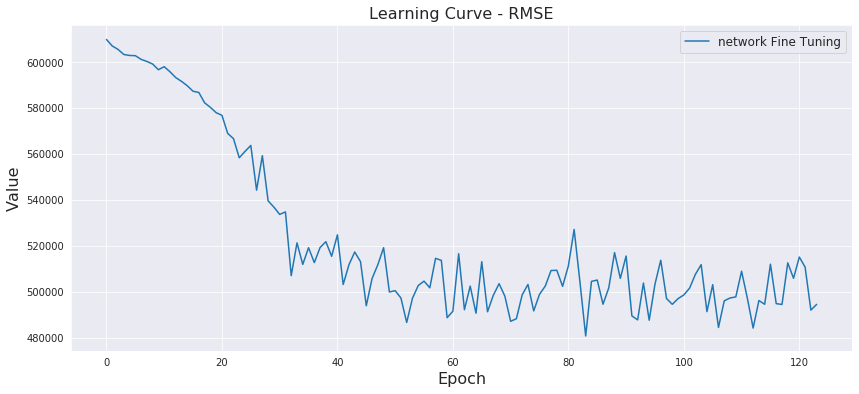

In [41]:
df_rmse = pd.DataFrame(data=np.vstack([df['RMSE'].values for df in df_history]).T, 
                       columns=[#'Re-training with Single task', 
                                #'Representation Transfer', 
                                'network Fine Tuning'])

with sns.axes_style("darkgrid"):   
    plt.figure(figsize=(14, 6))
    axes = sns.lineplot(data=df_rmse)
    axes.set_title('Learning Curve - RMSE', fontsize=16)
    axes.set_xlabel('Epoch', fontsize=16)
    axes.set_ylabel('Value', fontsize=16)
    plt.legend(fontsize='12', loc='upper right')
    plt.show()

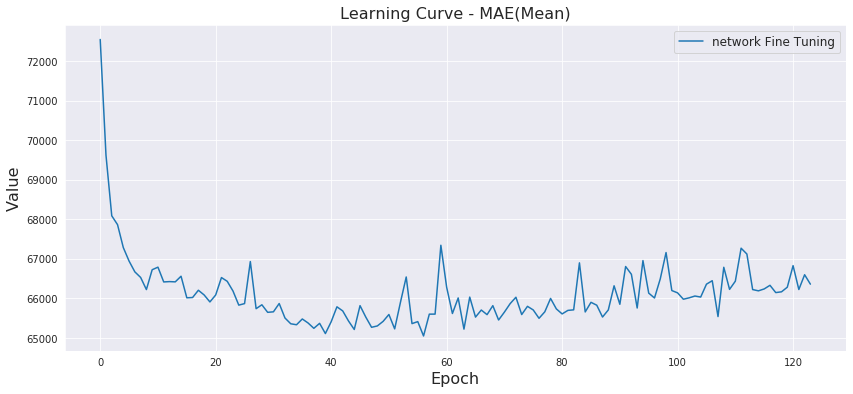

In [42]:
df_mae_mean = pd.DataFrame(data=np.vstack([df['MAE(mean)'].values for df in df_history]).T, 
                           columns=[#'Re-training with Single task', 
                                    #'Representation Transfer', 
                                    'network Fine Tuning'])

with sns.axes_style("darkgrid"):   
    plt.figure(figsize=(14, 6))
    axes = sns.lineplot(data=df_mae_mean)
    axes.set_title('Learning Curve - MAE(Mean)', fontsize=16)
    axes.set_xlabel('Epoch', fontsize=16)
    axes.set_ylabel('Value', fontsize=16)
    plt.legend(fontsize='12', loc='upper right')
    plt.show()

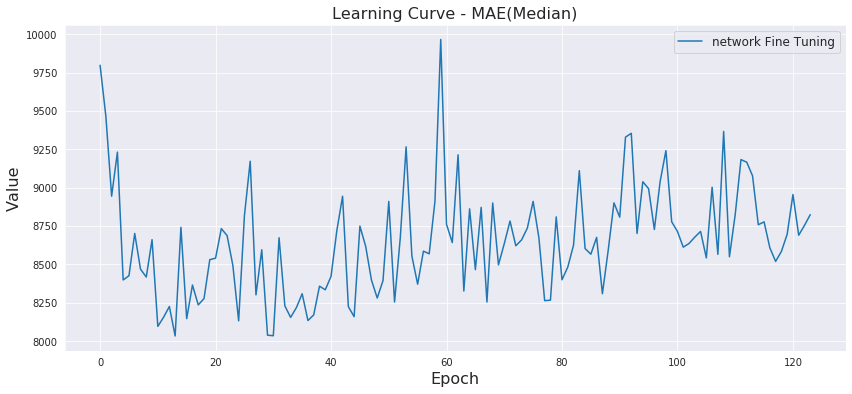

In [43]:
df_mae_median = pd.DataFrame(data=np.vstack([df['MAE(median)'].values for df in df_history]).T, 
                             columns=[#'Re-training with Single task', 
                                      #'Representation Transfer', 
                                      'network Fine Tuning'])

with sns.axes_style("darkgrid"):   
    plt.figure(figsize=(14, 6))
    axes = sns.lineplot(data=df_mae_median)
    axes.set_title('Learning Curve - MAE(Median)', fontsize=16)
    axes.set_xlabel('Epoch', fontsize=16)
    axes.set_ylabel('Value', fontsize=16)
    plt.legend(fontsize='12', loc='upper right')
    plt.show()

In [ ]:
#torch.save({
#    'dense_dims': dense_dims,
#    'sparse_dims': sparse_dims,
#    'hidden_dims': 64,
#    'n_layers': 2,
#    'use_chid': True,
#    'cell': 'GRU',
#    'bi': False,
#    'dropout': 0.1,
#    'out_dim': 1,
#    'model_state_dict': models[0].to('cpu').state_dict()
#}, './models/objamsum_retrain.pt')

In [ ]:
#torch.save({
#    'dense_dims': dense_dims,
#    'sparse_dims': sparse_dims,
#    'hidden_dims': 64,
#    'n_layers': 2,
#    'use_chid': True,
#    'cell': 'GRU',
#    'bi': False,
#    'dropout': 0.1,
#    'out_dim': 1,
#    'model_state_dict': models[1].to('cpu').state_dict()
#}, './models/objamsum_freeze.pt')

In [ ]:
#torch.save({
#    'dense_dims': dense_dims,
#    'sparse_dims': sparse_dims,
#    'hidden_dims': 64,
#    'n_layers': 2,
#    'use_chid': True,
#    'cell': 'GRU',
#    'bi': False,
#    'dropout': 0.1,
#    'out_dim': 1,
#    'model_state_dict': models[2].to('cpu').state_dict()
#}, './models/objamsum_finetune.pt')

<Figure size 576x576 with 0 Axes>

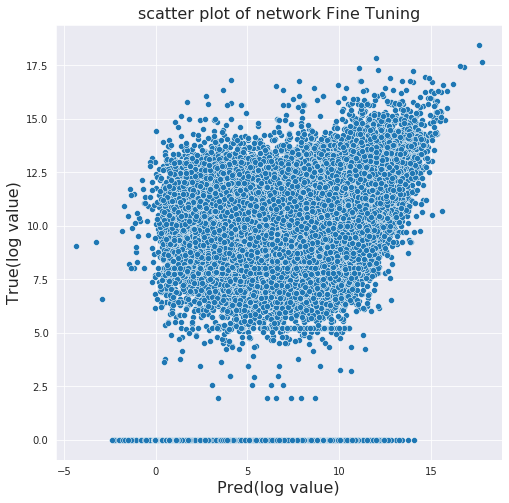

In [51]:
titles = ['Re-training with Single task', 'Representation Transfer', 'network Fine Tuning']

with sns.axes_style("darkgrid"):
    plt.figure(figsize=(8, 8))
    
    for i in range(2, 3):
        plt.figure(figsize=(8, 8))
        axes = sns.scatterplot(y=np.log1p(test_true_list[i]).flatten(), x=np.log1p(test_pred_list[i]).flatten())
        axes.set_xlabel('Pred(log value)', fontsize=16)
        axes.set_ylabel('True(log value)', fontsize=16)
        axes.set_title('scatter plot of '+titles[i], fontsize=16)

        plt.show()